In [1]:
# Import the classes
from thesisv3.classism import MusicFileManager, MusicSegmentAnalyzer, MusicVisualizer

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\.School\Thesisv3\.venv\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
file_manager = MusicFileManager()
file_manager.display_selector()

In [21]:
analyzer = MusicSegmentAnalyzer()
analyzer.load_score(file_manager.selected_file)
analyzer.analyze_segments()
analyzer.preprocess_segments()
analyzer.calculate_distance_matrix()

Calculated Edge Weight (0, 1)
Calculated Edge Weight (0, 2)
Calculated Edge Weight (0, 3)
Calculated Edge Weight (0, 4)
Calculated Edge Weight (0, 5)
Calculated Edge Weight (0, 6)
Calculated Edge Weight (0, 7)
Calculated Edge Weight (0, 8)
Calculated Edge Weight (0, 9)
Calculated Edge Weight (0, 10)
Calculated Edge Weight (0, 11)
Calculated Edge Weight (0, 12)
Calculated Edge Weight (0, 13)
Calculated Edge Weight (0, 14)
Calculated Edge Weight (0, 15)
Calculated Edge Weight (0, 16)
Calculated Edge Weight (0, 17)
Calculated Edge Weight (0, 18)
Calculated Edge Weight (0, 19)
Calculated Edge Weight (0, 20)
Calculated Edge Weight (0, 21)
Calculated Edge Weight (0, 22)
Calculated Edge Weight (0, 23)
Calculated Edge Weight (0, 24)
Calculated Edge Weight (0, 25)
Calculated Edge Weight (0, 26)
Calculated Edge Weight (0, 27)
Calculated Edge Weight (0, 28)
Calculated Edge Weight (0, 29)
Calculated Edge Weight (0, 30)
Calculated Edge Weight (0, 31)
Calculated Edge Weight (0, 32)
Calculated Edge W

In [22]:
analyzer.nmat

,onset_beats,onset_beats_in_measure,duration_beats,midi_pitch,pitch_class,octave,beat_strength,mobility,tessitura,expectancy,ir_symbol,pattern_index
0,0.0,0.0,1.0,68.0,8.0,4.0,1.0000,0.000000,0.000000,0.500000,ID,0.0
1,1.0,1.0,0.5,67.0,7.0,4.0,0.5000,0.000000,1.000000,0.581632,ID,0.0
2,1.5,1.5,0.5,68.0,8.0,4.0,0.2500,4.333333,8.485281,0.456034,ID,0.0
3,2.0,2.0,0.5,72.0,0.0,5.0,0.5000,0.409159,1.041511,0.581992,P,1.0
4,2.5,2.5,0.5,70.0,10.0,4.0,0.2500,0.576271,0.559017,0.591314,P,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
815,416.0,2.0,1/3,65.0,5.0,4.0,0.5000,0.364393,0.406889,0.593526,P,354.0
816,1249/3,7/3,1/3,66.0,6.0,4.0,0.0625,1.469413,0.678561,0.591569,P,354.0
817,1250/3,8/3,1/3,60.0,0.0,4.0,0.0625,1.283542,0.633661,0.591884,P,354.0
818,417.0,0.0,2.0,61.0,1.0,4.0,1.0000,12.529781,3.396478,0.572005,M,355.0


In [23]:
visualizer = MusicVisualizer(analyzer)

In [17]:
analyzer.distance_matrix

array([[ 0.        , 24.16183802, 20.89870133, ..., 25.30347128,
        28.90360777, 34.64107477],
       [24.16183802,  0.        ,  8.5989701 , ..., 25.99604832,
        21.3045808 , 42.03328957],
       [20.89870133,  8.5989701 ,  0.        , ..., 23.28588946,
        17.78753346, 35.32668604],
       ...,
       [25.30347128, 25.99604832, 23.28588946, ...,  0.        ,
        18.3546467 , 25.67797044],
       [28.90360777, 21.3045808 , 17.78753346, ..., 18.3546467 ,
         0.        , 31.26198114],
       [34.64107477, 42.03328957, 35.32668604, ..., 25.67797044,
        31.26198114,  0.        ]])

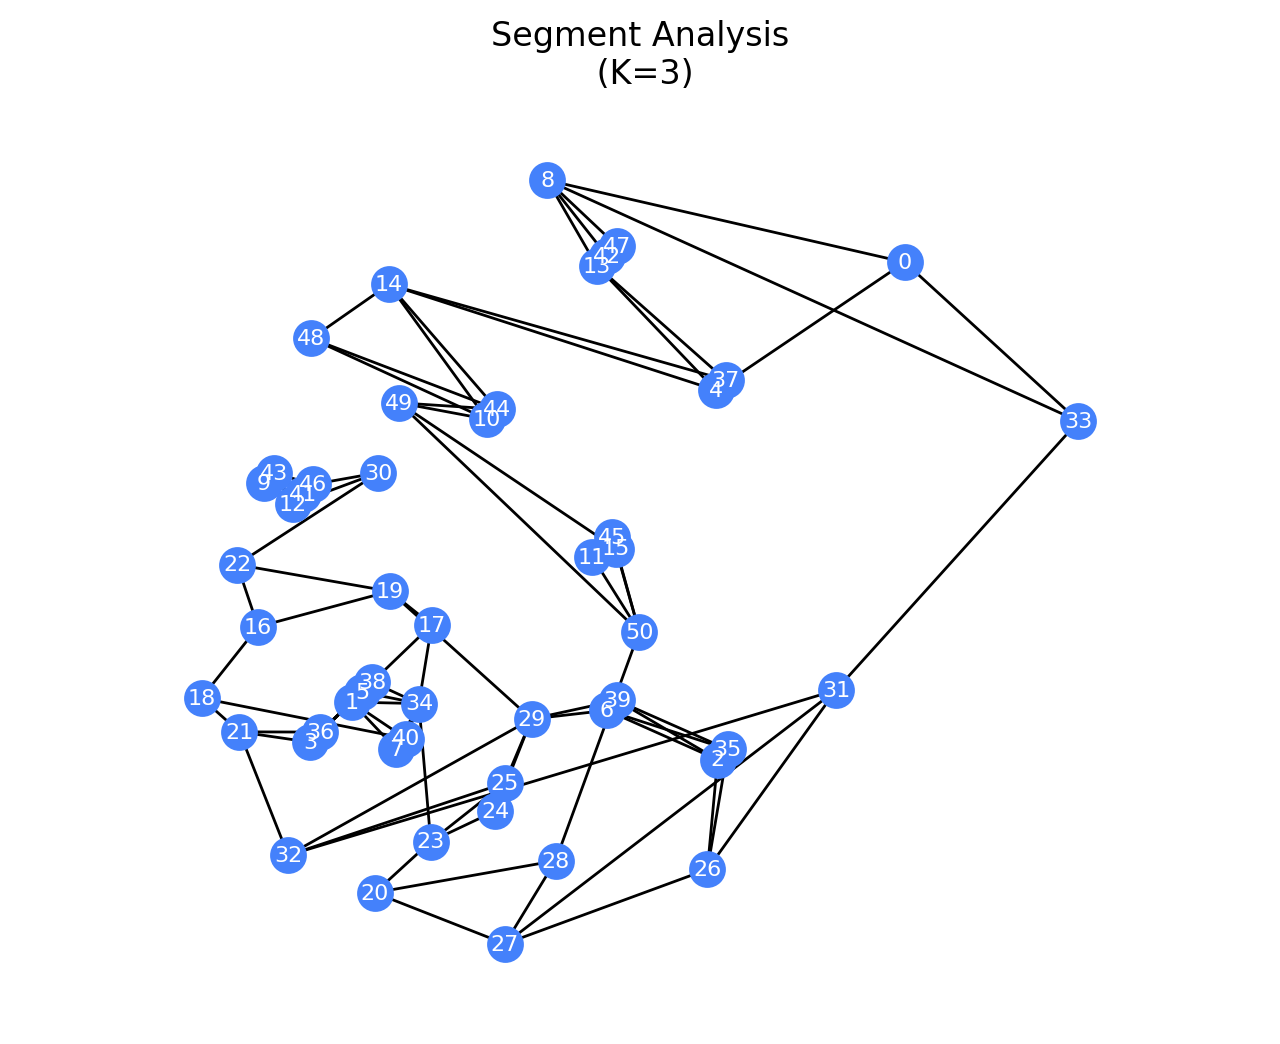

In [24]:
visualizer.visualize_knn_graph(k=3, title="Segment Analysis")

In [ ]:
import pandas as pd


def parse_score_elements(score: stream.Score, all_parts: bool = False) -> tuple[pd.DataFrame, list, list]:
    """
    Parses a music21 score object into a DataFrame of note attributes and lists of note and chord elements.
    By default, only processes the first part unless all_parts=True.

    Parameters:
    score (music21.stream.Score): The music21 score object to parse.
    all_parts (bool): If True, process all parts. If False, only process the first part. Defaults to False.

    Returns:
    tuple: A tuple containing:
        - pd.DataFrame: A DataFrame with onset (global and relative to measure), duration, MIDI pitch, pitch class, octave, and beat strength for each note.
        - list: A list of note and chord elements.
        - list: A list of all elements processed.
    """
    trashed_elements = 0
    narr = []
    sarr = []
    nmat = pd.DataFrame(columns=[
        'onset_beats',  # Onset in beats for the whole piece
        'onset_beats_in_measure',  # Onset relative to the measure
        'duration_beats',
        'midi_pitch',
        'pitch_class',
        'octave',
        'beat_strength'
    ])

    onset_beat = 0
    parts_to_process = score.parts[0]

    for part in parts_to_process:
        for measure in part.getElementsByClass(stream.Measure):
            measure_offset_in_score = measure.getOffsetInHierarchy(score)
            for element in measure:
                sarr.append(element)
                # Onset relative to the measure
                onset_beat_in_measure = element.offset
                # Onset relative to the whole piece
                duration_beats = element.duration.quarterLength

                # Beat strength calculation
                beat_strength = element.beatStrength if hasattr(element, 'beatStrength') else None

                if isinstance(element, chord.Chord):
                    # Use the root note of the chord
                    root_note = element.root()
                    pitch_class = root_note.pitchClass
                    octave = root_note.octave
                    midi_pitch = root_note.midi
                    row = [
                        onset_beat,
                        onset_beat_in_measure,
                        duration_beats,
                        midi_pitch,
                        pitch_class,
                        octave,
                        beat_strength
                    ]
                    nmat.loc[len(nmat)] = row
                    narr.append(element)
                elif isinstance(element, note.Rest):
                    # Represent rest with None for pitch attributes
                    row = [
                        onset_beat,
                        onset_beat_in_measure,
                        duration_beats,
                        0,
                        0,
                        0,
                        beat_strength
                    ]
                    nmat.loc[len(nmat)] = row
                    narr.append(element)
                elif isinstance(element, note.Note):
                    pitch_class = element.pitch.pitchClass
                    octave = element.pitch.octave
                    midi_pitch = element.pitch.midi
                    row = [
                        onset_beat,
                        onset_beat_in_measure,
                        duration_beats,
                        midi_pitch,
                        pitch_class,
                        octave,
                        beat_strength
                    ]
                    nmat.loc[len(nmat)] = row
                    narr.append(element)
                else:
                    trashed_elements += 1
                onset_beat += duration_beats

    return nmat, narr, sarr


In [ ]:
import pandas as pd
trashed_elements = 0
narr = []
sarr = []
nmat = pd.DataFrame(columns=[
    'onset_beats',  # Onset in beats for the whole piece
    'onset_beats_in_measure',  # Onset relative to the measure
    'duration_beats',
    'midi_pitch',
    'pitch_class',
    'octave',
    'beat_strength'
])

onset_beat = 0
parts_to_process = [score.parts[0]]

In [ ]:
for part in parts_to_process:
    for measure in part.getElementsByClass(stream.Measure):
        for element in measure:
            print(element)
            # if isinstance(element, stream.Voice):
            #     print("\n")
            #     print(element)
            #     duration_beats = element.duration.quarterLength
            #     print(duration_beats)
            #     print(element.offset)
            #     for subelement in element.flatten():
            #         print(subelement)
            #         duration_beats = subelement.duration.quarterLength
            #         print(duration_beats)
            #         print(subelement.offset)
            # else:
            #     print(element)

In [ ]:
for part in parts_to_process:
    for measure in part.getElementsByClass(stream.Measure):
        measure_offset_in_score = measure.getOffsetInHierarchy(score)
        for element in measure:
            sarr.append(element)
            # Onset relative to the measure
            onset_beat_in_measure = element.offset
            # Onset relative to the whole piece
            duration_beats = element.duration.quarterLength

            # Beat strength calculation
            beat_strength = element.beatStrength if hasattr(element, 'beatStrength') else None

            if isinstance(element, chord.Chord):
                # Use the root note of the chord
                root_note = element.root()
                pitch_class = root_note.pitchClass
                octave = root_note.octave
                midi_pitch = root_note.midi
                row = [
                    onset_beat,
                    onset_beat_in_measure,
                    duration_beats,
                    midi_pitch,
                    pitch_class,
                    octave,
                    beat_strength
                ]
                nmat.loc[len(nmat)] = row
                narr.append(element)
            elif isinstance(element, note.Rest):
                # Represent rest with None for pitch attributes
                row = [
                    onset_beat,
                    onset_beat_in_measure,
                    duration_beats,
                    0,
                    0,
                    0,
                    beat_strength
                ]
                nmat.loc[len(nmat)] = row
                narr.append(element)
            elif isinstance(element, note.Note):
                pitch_class = element.pitch.pitchClass
                octave = element.pitch.octave
                midi_pitch = element.pitch.midi
                row = [
                    onset_beat,
                    onset_beat_in_measure,
                    duration_beats,
                    midi_pitch,
                    pitch_class,
                    octave,
                    beat_strength
                ]
                nmat.loc[len(nmat)] = row
                narr.append(element)
            else:
                trashed_elements += 1
            onset_beat += duration_beats

In [ ]:
narr

gippity


In [ ]:

trashed_elements = 0
narr = []
sarr = []
nmat = pd.DataFrame(columns=[
    'onset_beats',
    'onset_beats_in_measure',
    'duration_beats',
    'midi_pitch',
    'pitch_class',
    'octave',
    'beat_strength'
])

for part in score.parts:
    for element in part.flatten():
        sarr.append(element)
        print(element)

In [ ]:

        global_onset = element.offset
        # Compute onset relative to the current measure if available.
        measure_context = element.getContextByClass('Measure')
        if measure_context is not None:
            onset_in_measure = element.offset - measure_context.offset
        else:
            onset_in_measure = element.offset

        duration_beats = element.duration.quarterLength
        beat_strength = getattr(element, 'beatStrength', None)

        if isinstance(element, chord.Chord):
            root = element.root()
            midi_pitch = root.midi
            pitch_class = root.pitchClass
            octave = root.octave
            row = [
                global_onset,
                onset_in_measure,
                duration_beats,
                midi_pitch,
                pitch_class,
                octave,
                beat_strength
            ]
            nmat.loc[len(nmat)] = row
            narr.append(element)
        elif isinstance(element, note.Note):
            midi_pitch = element.pitch.midi
            pitch_class = element.pitch.pitchClass
            octave = element.pitch.octave
            row = [
                global_onset,
                onset_in_measure,
                duration_beats,
                midi_pitch,
                pitch_class,
                octave,
                beat_strength
            ]
            nmat.loc[len(nmat)] = row
            narr.append(element)
        elif isinstance(element, note.Rest):
            # For rests, we use None for pitch-related attributes.
            row = [
                global_onset,
                onset_in_measure,
                duration_beats,
                None,
                None,
                None,
                beat_strength
            ]
            nmat.loc[len(nmat)] = row
            narr.append(element)
        else:
            trashed_elements += 1



In [ ]:
sarr

In [ ]:
import copy
from music21 import stream, note, chord

def color_stream(original_score):
    """
    Creates a deep copy of the input score and colors all elements inside Voice objects.

    Parameters:
    original_score (music21.stream.Score): The original music21 score.

    Returns:
    music21.stream.Score: A new score with colored Voice elements.
    """
    # Make a deep copy of the original score to preserve its structure
    new_score = copy.deepcopy(original_score)

    # Iterate over the parts of the new_score
    for part in new_score.parts:
        # Iterate over measures in the part
        for measure in part.getElementsByClass(stream.Measure):
            # Iterate over elements in the measure
            for element in measure:
                if isinstance(element, stream.Voice):  # Check if the element is a Voice
                    for sub_element in element:  # Iterate through the Voice's elements
                        if isinstance(sub_element, (note.Note, chord.Chord, note.Rest)):
                            sub_element.style.color = "blue"  # Set color for notes/chords/rests
                elif isinstance(element, (note.Note, chord.Chord, note.Rest)):
                    element.style.color = "black"  # Keep regular elements uncolored or default

    return new_score


In [ ]:
color_stream(score).show()

In [ ]:
from fractions import Fraction
import copy
import copy
import os
import tempfile
from fractions import Fraction

import ipywidgets as widgets
import pandas as pd
from IPython.display import display, clear_output
from music21 import (
    stream,
    note,
    chord,
    expressions,
    layout,
    environment
)
from pygame import mixer


def visualize_segment(segments, segment_index, original_score, show_score=True):
    """
    Visualizes a specific segment from a musical score using an additive approach,
    building a new score with only the desired elements.
    """
    def approximate_to_fraction(df, column='onset_beats', max_denominator=16):
        df = df.copy()
        df[column] = df[column].apply(
            lambda x: float(Fraction(x).limit_denominator(max_denominator))
        )
        return df

    # Define the color map for IR symbols
    color_map = {
        'P': 'blue',  # IR1: P (Process)
        'D': 'green',  # IR2: D (Duplication)
        'IP': 'red',  # IR3: IP (Intervallic Process)
        'ID': 'orange',  # IR4: ID (Intervallic Duplication)
        'VP': 'purple',  # IR5: VP (Vector Process)
        'R': 'cyan',  # IR6: R (Reversal)
        'IR': 'magenta',  # IR7: IR (Intervallic Reversal)
        'VR': 'yellow',  # IR8: VR (Vector Reversal)
        'M': 'pink',  # IR9: M (Monad)
        'd': 'lime',  # IR10 d (Dyad)
        'rest': 'black'  # Default color for rests
    }

    if not isinstance(segments, list) or segment_index >= len(segments):
        raise ValueError(f"Invalid segment index. Must be between 0 and {len(segments) - 1}")

    # Make a deep copy of the original score to preserve its structure
    score = copy.deepcopy(original_score)

    # Create a completely new score
    new_score = stream.Score()

    # First check if we have any staff groups (like piano's grand staff)
    part_groups = []
    for element in score.elements:
        if isinstance(element, layout.StaffGroup):
            part_groups.append(copy.deepcopy(element))

    # Add any staff groups to the new score first
    for group in part_groups:
        new_score.append(group)

    # Copy parts while preserving their relationships
    for part in score.parts:
        new_part = stream.Part()

        # Preserve staff layout information
        for elem in part.getElementsByClass('LayoutClass'):
            new_part.append(copy.deepcopy(elem))

        # Copy measures and their contents
        for measure in part.getElementsByClass('Measure'):
            new_measure = stream.Measure()
            new_measure.number = measure.number

            # Copy time signature if it exists
            ts = measure.timeSignature
            if ts:
                new_measure.timeSignature = copy.deepcopy(ts)
            # Copy clef if it exists
            cl = measure.clef
            if cl:
                new_measure.clef = copy.deepcopy(cl)
            # Copy key signature if it exists
            ks = measure.keySignature
            if ks:
                new_measure.keySignature = copy.deepcopy(ks)

            # Copy notes, rests, and chords
            for elem in measure.getElementsByClass(['Note', 'Rest', 'Chord']):
                new_measure.append(copy.deepcopy(elem))

            new_part.append(new_measure)

        # Preserve any staff identifiers or group memberships
        if hasattr(part, 'staffName'):
            new_part.staffName = part.staffName
        if hasattr(part, 'groupName'):
            new_part.groupName = part.groupName

        new_score.append(new_part)

    # Add segment number as a text expression at the top
    segment_text = expressions.TextExpression(f'Segment {segment_index}')
    segment_text.style.absoluteY = 75  # Position above the staff
    segment_text.style.fontSize = 14
    first_measure = new_score.parts[0].getElementsByClass('Measure')[0]
    first_measure.insert(0, segment_text)

    # Get the selected segment
    segment = segments[segment_index]
    segment = approximate_to_fraction(segment, column='onset_beats', max_denominator=16)

    # Create a set of onsets in the segment for quick lookup
    segment_onsets = set(segment['onset_beats'].values)

    # Iterate over the parts of the new_score
    for part in new_score.parts:
        measures_to_keep = []
        # First pass: identify measures with segment notes and transform notes
        for measure in part.getElementsByClass(stream.Measure):
            has_segment_notes = False
            for element in measure:
                if isinstance(element, (note.Note, note.Rest, chord.Chord)):
                    element_offset = element.getOffsetInHierarchy(new_score)

                    if element_offset in segment_onsets:
                        has_segment_notes = True
                        # Find the corresponding row in our segment DataFrame
                        segment_row = segment[segment['onset_beats'] == element_offset].iloc[0]

                        # If it's a rest in our segment data
                        if segment_row['midi_pitch'] == 0:
                            new_element = note.Rest(quarterLength=element.duration.quarterLength)
                            new_element.style.color = color_map['rest']
                        else:
                            # Create a new note with the pitch from our segment
                            new_element = note.Note(
                                pitch=segment_row['midi_pitch'],
                                quarterLength=element.duration.quarterLength
                            )

                            # Add IR symbol and color if available
                            if 'ir_symbol' in segment_row:
                                ir_symbol = segment_row['ir_symbol']
                                new_element.lyric = ir_symbol
                                if ir_symbol in color_map:
                                    new_element.style.color = color_map[ir_symbol]

                        # Replace the element in the measure
                        measure.replace(element, new_element)
                    else:
                        # Remove notes not in our segment
                        measure.remove(element)

            if has_segment_notes:
                measures_to_keep.append(measure)

        # Clear all measures from the part
        for measure in part.getElementsByClass(stream.Measure):
            part.remove(measure)

        # Add back only the measures we want to keep
        for measure in measures_to_keep:
            part.append(measure)

        # If the part is empty after removing measures, remove it from the score
        if len(part.getElementsByClass(stream.Measure)) == 0:
            new_score.remove(part)

    # --- FIX: Ensure the score is well-formed before showing/exporting ---
    new_score.makeNotation(inPlace=True)

    # Show the updated score if requested
    if show_score:
        new_score.show()

    return new_score


In [ ]:
analyzer.segments[2]

In [ ]:
visualize_segment(analyzer.segments, 3, analyzer.parsed_score)

In [ ]:
visualize_notes_with_symbols(analyzer.ir_symbols, analyzer.parsed_score).show()
